In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
test_df = pd.read_csv('../data/01_raw/test.csv')
tain_df = pd.read_csv('../data/01_raw/train.csv')

In [3]:
final_features = [
    # [핵심] 범주형 변수 (반드시 One-Hot Encoding 처리: 0/1)
    'international_plan', 
    'voice_mail_plan',
    
    # [핵심] 수치형 변수 - 이탈과 상관관계가 높은 변수
    'number_customer_service_calls',  # 가장 중요도가 높음
    'total_day_minutes',              # 사용량 척도
    'total_intl_calls',               # 국제전화 빈도
    'total_intl_charge',              # 국제전화 요금 민감도
    
    # [보조] 기타 사용량 (다중공선성 방지를 위해 Charge는 제외하고 Minutes만 사용 권장)
    'total_eve_minutes',
    'total_night_minutes',
    'number_vmail_messages'
]

# 제외할 컬럼 (Drop List)
# 1. state, area_code: 범주가 너무 많아 모델 복잡도만 높이고 예측력은 낮음 (필요시 타겟 인코딩)
# 2. total_xxx_charge: minutes와 100% 상관관계이므로 중복 정보임. 제거 권장.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. 데이터 로드 및 확인
# train.csv 파일을 로드합니다.
try:
    df = pd.read_csv('../data/01_raw/train.csv')
    print("✅ train.csv 파일 로드 완료")
except FileNotFoundError:
    print("❌ train.csv 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    exit()

# 2. 불필요한/중복 컬럼 제거 (Feature Selection)

# - 'phone_number': 식별자이므로 제거
# - 'area_code', 'state': 범주가 많고 이탈 예측 중요도가 낮아 제거 (모델 복잡도 방지)
# - Charge 컬럼: Minutes 컬럼과 상관관계가 1이므로 제거 (다중공선성 방지)
drop_cols = [
    'phone_number', 
    'area_code', 
    'state', 
    'total_day_charge', 
    'total_eve_charge', 
    'total_night_charge', 
    'total_intl_charge'
]

df = df.drop(columns=drop_cols, errors='ignore')
print(f"🗑️ 제거된 컬럼: {drop_cols}")
print(f"현재 남은 컬럼: {df.columns.tolist()}")

# 3. Target 변수(Churn) 인코딩 (Label Encoding: 'yes' -> 1, 'no' -> 0)
df['churn'] = df['churn'].map({'yes': 1, 'no': 0})
print("🎯 Target 변수(churn) 인코딩 완료: yes=1, no=0")

# 4. Feature와 Target 분리
X = df.drop('churn', axis=1)  # 독립 변수
y = df['churn']              # 종속 변수 (타겟)

# 5. 전처리를 위한 컬럼 타입 정의 (파이프라인 준비)
# 수치형: 스케일링 필요
numerical_features = X.select_dtypes(include=['number']).columns.tolist()
# 범주형: 원-핫 인코딩 필요
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\n📊 수치형 컬럼 ({len(numerical_features)}개): {numerical_features}")
print(f"🔡 범주형 컬럼 ({len(categorical_features)}개): {categorical_features}")

# 6. 전처리 파이프라인 구성 (ColumnTransformer 사용)

# 수치형 변수 파이프라인: 표준화 (StandardScaler)
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 범주형 변수 파이프라인: 원-핫 인코딩 (OneHotEncoder)
# sparse_output=False: 배열 형태로 출력하도록 설정
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer: 각 타입에 맞는 전처리를 동시에 적용
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough' # 정의되지 않은 컬럼은 그대로 둠 (여기서는 없음)
)

print("\n⚙️ 전처리 파이프라인(ColumnTransformer) 구성 완료")

# 7. 데이터 변환 및 결과 확인
X_processed = preprocessor.fit_transform(X)

# 변환된 데이터의 컬럼 이름 추출 (OneHotEncoder 적용 후 컬럼 이름 포함)
# get_feature_names_out()을 사용하여 전처리 후의 컬럼 이름을 얻습니다.
feature_names = preprocessor.get_feature_names_out()

# NumPy 배열을 다시 Pandas DataFrame으로 변환 (가독성 및 모델링 편의성 위해)
X_df_processed = pd.DataFrame(X_processed, columns=feature_names)

print("\n--- 전처리 결과 데이터프레임 (X_df_processed) ---")
print(f"최종 Feature 개수: {X_df_processed.shape[1]}개")
print(X_df_processed.head())

# 8. 학습/테스트 데이터 분리
# 통상적인 머신러닝 학습을 위해 훈련 데이터와 검증 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_df_processed, y, test_size=0.2, random_state=42, stratify=y
)

print("\n--- 학습 및 테스트 데이터 분리 완료 ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train (Churn 비율): {y_train.mean():.4f}")

# 이제 X_train, X_test, y_train, y_test를 사용하여 Churn 예측 모델을 학습시킬 수 있습니다.

✅ train.csv 파일 로드 완료
🗑️ 제거된 컬럼: ['phone_number', 'area_code', 'state', 'total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge']
현재 남은 컬럼: ['account_length', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_eve_minutes', 'total_eve_calls', 'total_night_minutes', 'total_night_calls', 'total_intl_minutes', 'total_intl_calls', 'number_customer_service_calls', 'churn']
🎯 Target 변수(churn) 인코딩 완료: yes=1, no=0

📊 수치형 컬럼 (11개): ['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_eve_minutes', 'total_eve_calls', 'total_night_minutes', 'total_night_calls', 'total_intl_minutes', 'total_intl_calls', 'number_customer_service_calls']
🔡 범주형 컬럼 (2개): ['international_plan', 'voice_mail_plan']

⚙️ 전처리 파이프라인(ColumnTransformer) 구성 완료

--- 전처리 결과 데이터프레임 (X_df_processed) ---
최종 Feature 개수: 15개
   num__account_length  num__number_vmail_messages  num__total_day_minutes  \
0          

✅ 데이터 로드 및 Target 인코딩 완료


--- 1. CS 통화 횟수별 이탈률 ---


C:\Users\user\AppData\Local\Temp\ipykernel_5100\832306356.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54943 (\N{HANGUL SYLLABLE HOES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from fon

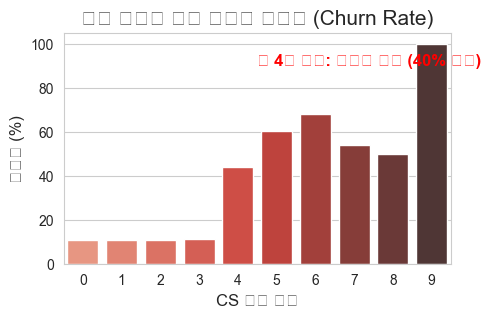



--- 2. 플랜 가입 여부별 이탈률 ---


C:\Users\user\AppData\Local\Temp\ipykernel_5100\832306356.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\user\AppData\Local\Temp\ipykernel_5100\832306356.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\user\AppData\Local\Temp\ipykernel_5100\832306356.py:83: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_5100\832306356.py:83: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_5100\832306356.py:83: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) Arial.


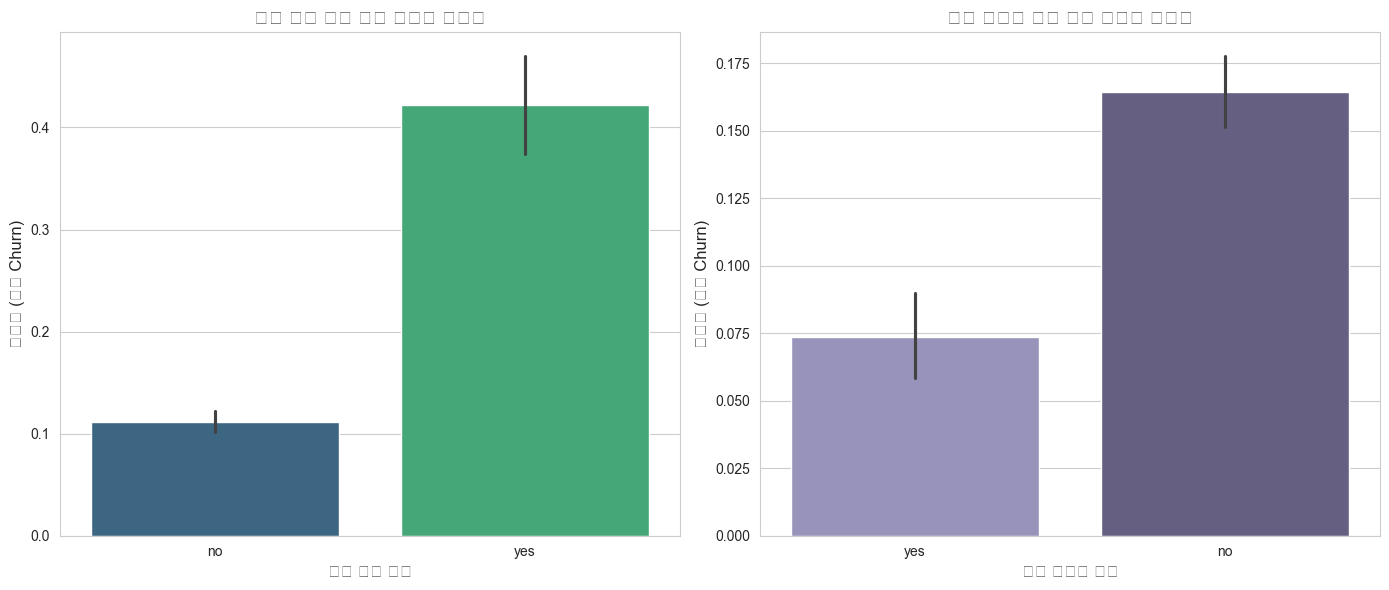



--- 3. 주간 사용량 분포 (히스토그램) ---


c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\minic

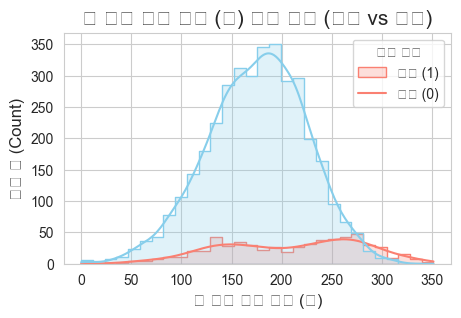



--- 4. 핵심 변수 간 종합 Pair Plot (관계 및 이탈 여부) ---


--- 핵심 변수 간 Pair Plot 생성 중 (시간 소요될 수 있음) ---


c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54645 (\N{HANGUL SYLLABLE HAEG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\mini

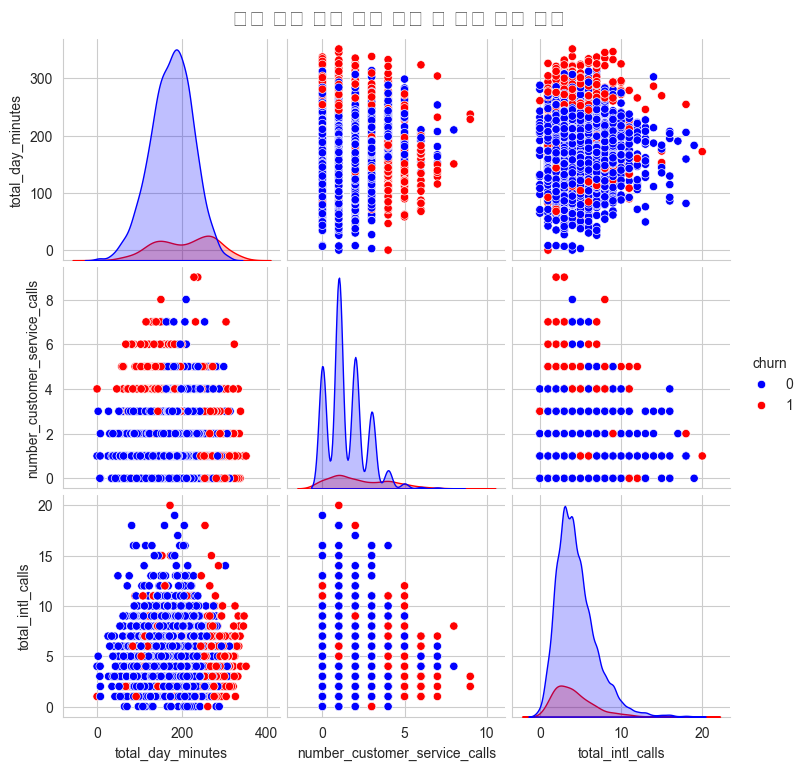

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 범용적인 설정: 폰트 설정 제거 (에러 방지), 스타일만 적용
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (5, 3) # 기본 피규어 크기 설정
plt.rcParams['axes.unicode_minus'] = False 

# 1. 데이터 로드 및 Target 인코딩
try:
    df = pd.read_csv('../data/01_raw/train.csv')
    df['churn'] = df['churn'].map({'yes': 1, 'no': 0})
    print("✅ 데이터 로드 및 Target 인코딩 완료")
except FileNotFoundError:
    print("❌ train.csv 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    exit()

## --- 새로운 시각화 함수 정의 ---

def plot_churn_rate_by_cs_calls_simple(data):
    """
    [CS 통화 횟수] 이탈률을 Bar Plot으로, 위험 임계점을 텍스트로 강조
    """
    cs_churn = data.groupby('number_customer_service_calls')['churn'].mean().reset_index()
    cs_churn['churn_rate'] = cs_churn['churn'] * 100
    
    plt.figure(figsize=(5, 3))
    bar = sns.barplot(
        x='number_customer_service_calls', 
        y='churn_rate', 
        data=cs_churn, 
        palette='Reds_d'
    )
    
    plt.title('고객 서비스 통화 횟수별 이탈률 (Churn Rate)', fontsize=15)
    plt.xlabel('CS 통화 횟수', fontsize=12)
    plt.ylabel('이탈률 (%)', fontsize=12)
    
    # 4회 이상에서 이탈률이 급증함을 텍스트로 표시
    plt.text(
        4.5, 
        max(cs_churn['churn_rate']) * 0.9, 
        '🚨 4회 이상: 이탈률 급증 (40% 초과)', 
        color='red', 
        fontsize=12, 
        fontweight='bold'
    )
    
    plt.show()

def plot_binary_features_comparison(data):
    """
    [플랜 가입 여부] 국제전화/음성사서함 플랜별 이탈률 비교 (Subplots)
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. 국제 전화 플랜
    sns.barplot(
        x='international_plan', 
        y='churn', 
        data=data, 
        ax=axes[0], 
        palette='viridis'
    )
    axes[0].set_title('국제 전화 플랜 가입 여부별 이탈률', fontsize=14)
    axes[0].set_xlabel('국제 전화 플랜', fontsize=12)
    axes[0].set_ylabel('이탈률 (평균 Churn)', fontsize=12)
    
    # 2. 음성 사서함 플랜
    sns.barplot(
        x='voice_mail_plan', 
        y='churn', 
        data=data, 
        ax=axes[1], 
        palette='Purples_d'
    )
    axes[1].set_title('음성 사서함 플랜 가입 여부별 이탈률', fontsize=14)
    axes[1].set_xlabel('음성 사서함 플랜', fontsize=12)
    axes[1].set_ylabel('이탈률 (평균 Churn)', fontsize=12)
    
    plt.tight_layout()
    plt.show()

def plot_usage_histogram(data, column_name, title):
    """
    [주요 사용량] 이탈 고객/유지 고객의 사용량 분포를 히스토그램으로 비교
    """
    plt.figure(figsize=(5, 3))
    
    sns.histplot(
        data=data, 
        x=column_name, 
        hue='churn', 
        bins=30, 
        kde=True, # 밀도 추정선 추가
        palette={0: 'skyblue', 1: 'salmon'},
        element='step' # 막대를 겹쳐서 비교하기 쉽게 설정
    )
    
    plt.title(f'{title} 분포 비교 (이탈 vs 유지)', fontsize=15)
    plt.xlabel(title, fontsize=12)
    plt.ylabel('고객 수 (Count)', fontsize=12)
    plt.legend(title='이탈 여부', labels=['이탈 (1)', '유지 (0)'])
    plt.show()

def plot_key_features_pairplot(data):
    """
    [종합 분석] 핵심 수치형 변수들의 쌍별 관계 및 이탈 여부 확인 (Pair Plot)
    """
    key_features = [
        'total_day_minutes', 
        'number_customer_service_calls', 
        'total_intl_calls', 
        'churn'
    ]
    
    print("\n\n--- 핵심 변수 간 Pair Plot 생성 중 (시간 소요될 수 있음) ---")
    
    # 이탈 여부(churn)를 기준으로 색상을 구분하여 시각화
    sns.pairplot(
        data[key_features], 
        hue='churn', 
        diag_kind='kde', # 대각선에는 밀도 추정 그래프 표시
        palette={0: 'blue', 1: 'red'}
    )
    plt.suptitle('핵심 변수 간의 쌍별 관계 및 이탈 고객 분포', y=1.02, fontsize=16)
    plt.show()


## --- 실행 부분 ---

print("\n\n--- 1. CS 통화 횟수별 이탈률 ---")
plot_churn_rate_by_cs_calls_simple(df)

print("\n\n--- 2. 플랜 가입 여부별 이탈률 ---")
plot_binary_features_comparison(df)

print("\n\n--- 3. 주간 사용량 분포 (히스토그램) ---")
plot_usage_histogram(df, 'total_day_minutes', '총 주간 통화 시간 (분)')

print("\n\n--- 4. 핵심 변수 간 종합 Pair Plot (관계 및 이탈 여부) ---")
plot_key_features_pairplot(df)

✅ Data Loaded and Target Encoded successfully.


--- 1. Churn Rate by CS Calls ---


C:\Users\user\AppData\Local\Temp\ipykernel_5100\1139130209.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
c:\Users\user\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


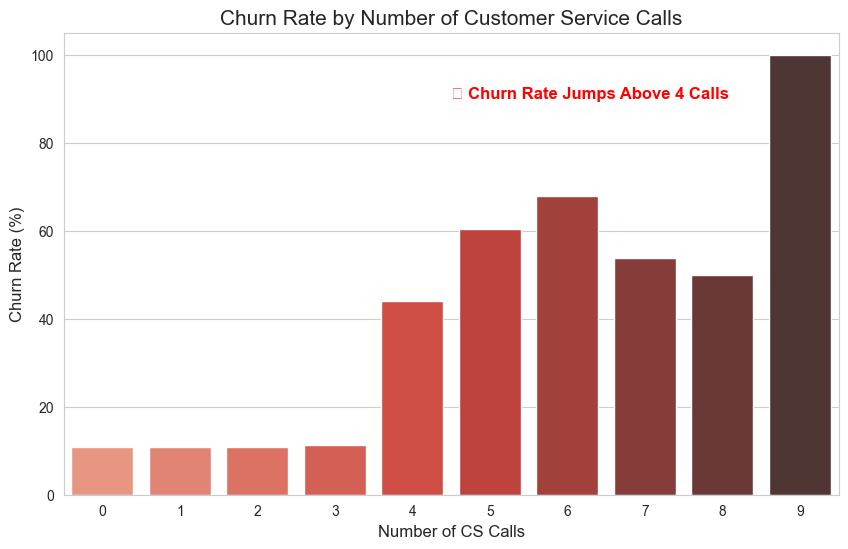



--- 2. Churn Rate by Plan Status ---


C:\Users\user\AppData\Local\Temp\ipykernel_5100\1139130209.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\user\AppData\Local\Temp\ipykernel_5100\1139130209.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


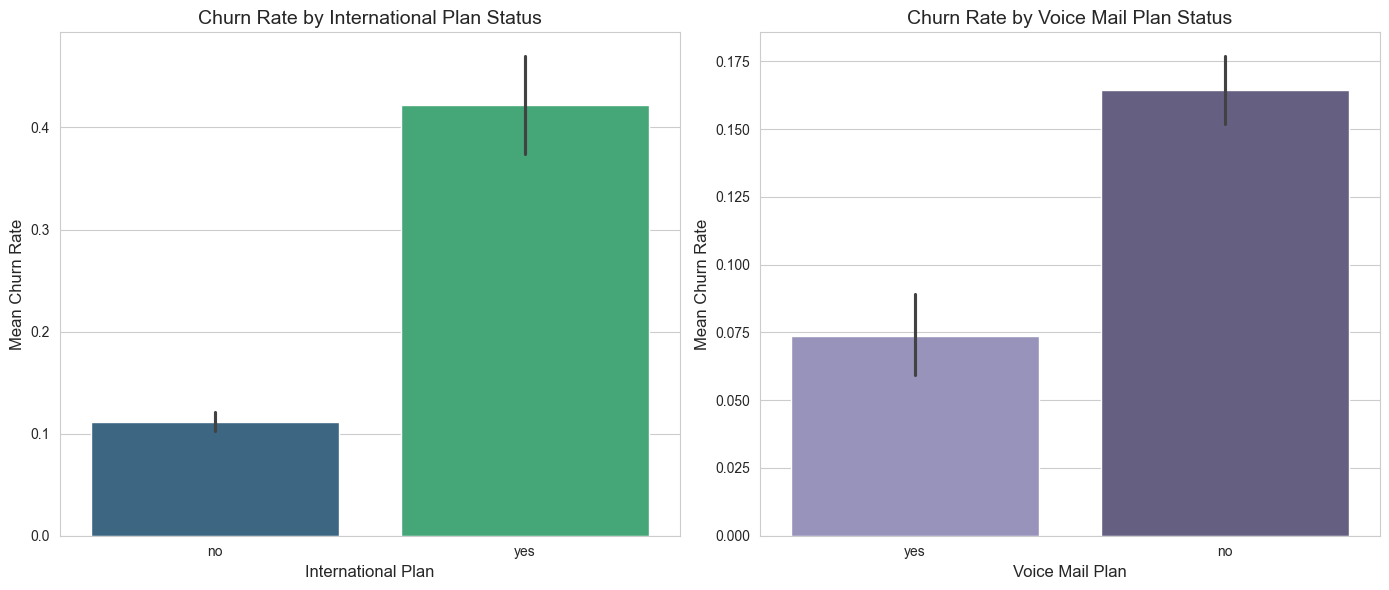



--- 3. Total Day Minutes Distribution (Histogram) ---


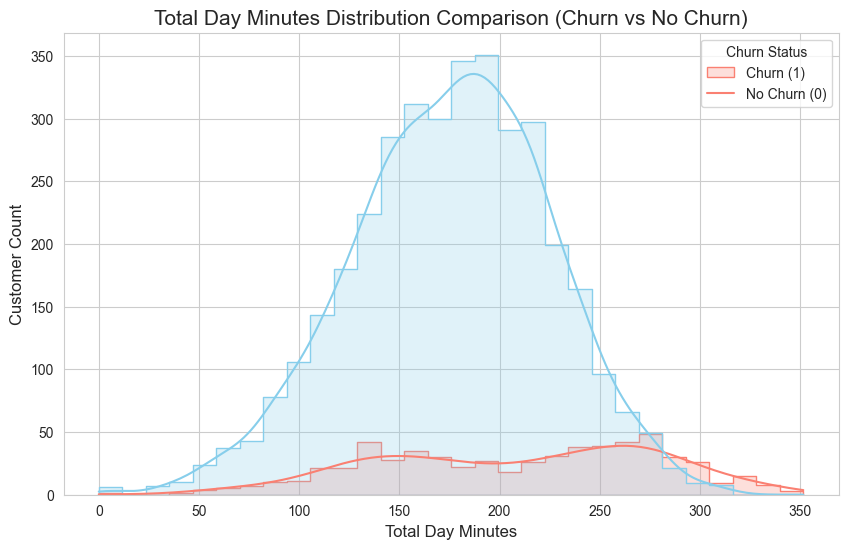



--- 4. Key Feature Pair Plot ---


--- Generating Key Feature Pair Plot (May take a moment) ---


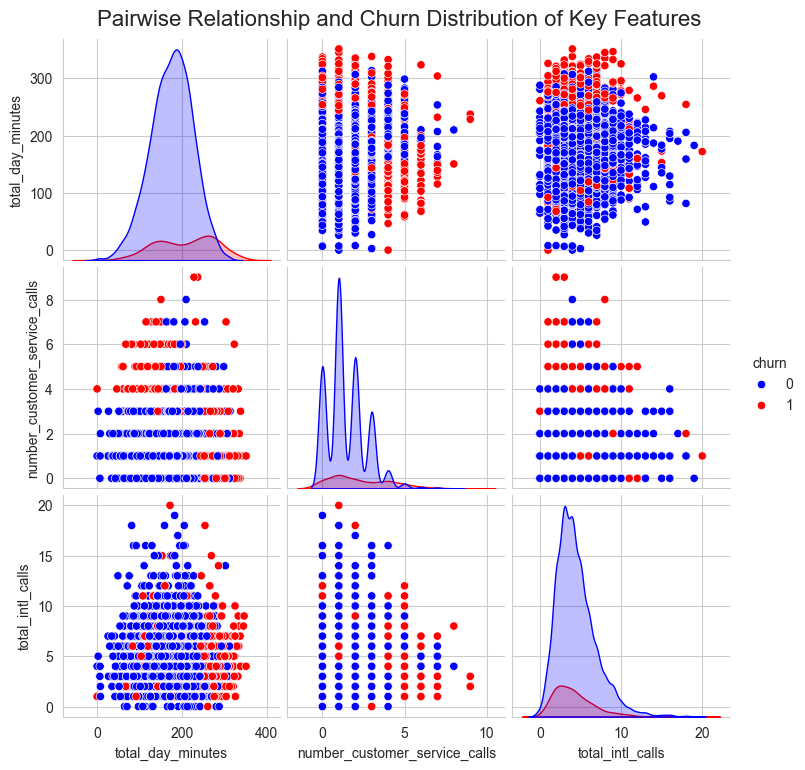

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 깨짐을 방지하기 위해 한글 폰트 관련 설정은 모두 제거합니다.
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
# Matplotlib의 기본 폰트는 영어 환경에서 문제 없이 작동합니다.

# 1. 데이터 로드 및 Target 인코딩
try:
    df = pd.read_csv('../data/01_raw/train.csv')
    df['churn'] = df['churn'].map({'yes': 1, 'no': 0})
    print("✅ Data Loaded and Target Encoded successfully.")
except FileNotFoundError:
    print("❌ train.csv file not found. Please check the path.")
    exit()

## --- 깨짐 방지 시각화 함수 정의 (제목/레이블 영문화) ---

def plot_churn_rate_by_cs_calls_eng(data):
    """
    [CS Calls] Churn Rate by Customer Service Calls (Bar Plot)
    """
    cs_churn = data.groupby('number_customer_service_calls')['churn'].mean().reset_index()
    cs_churn['churn_rate'] = cs_churn['churn'] * 100
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='number_customer_service_calls', 
        y='churn_rate', 
        data=cs_churn, 
        palette='Reds_d'
    )
    
    plt.title('Churn Rate by Number of Customer Service Calls', fontsize=15)
    plt.xlabel('Number of CS Calls', fontsize=12)
    plt.ylabel('Churn Rate (%)', fontsize=12)
    
    # Emphasize the critical threshold
    plt.text(
        4.5, 
        max(cs_churn['churn_rate']) * 0.9, 
        '🚨 Churn Rate Jumps Above 4 Calls', 
        color='red', 
        fontsize=12, 
        fontweight='bold'
    )
    
    plt.show()
    # 

def plot_binary_features_comparison_eng(data):
    """
    [Plans] Churn Rate Comparison for International and Voice Mail Plans
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. International Plan
    sns.barplot(
        x='international_plan', 
        y='churn', 
        data=data, 
        ax=axes[0], 
        palette='viridis'
    )
    axes[0].set_title('Churn Rate by International Plan Status', fontsize=14)
    axes[0].set_xlabel('International Plan', fontsize=12)
    axes[0].set_ylabel('Mean Churn Rate', fontsize=12)
    
    # 2. Voice Mail Plan
    sns.barplot(
        x='voice_mail_plan', 
        y='churn', 
        data=data, 
        ax=axes[1], 
        palette='Purples_d'
    )
    axes[1].set_title('Churn Rate by Voice Mail Plan Status', fontsize=14)
    axes[1].set_xlabel('Voice Mail Plan', fontsize=12)
    axes[1].set_ylabel('Mean Churn Rate', fontsize=12)
    
    plt.tight_layout()
    plt.show()

def plot_usage_histogram_eng(data, column_name, title):
    """
    [Usage] Distribution of Total Day Minutes (Histogram)
    """
    plt.figure(figsize=(10, 6))
    
    sns.histplot(
        data=data, 
        x=column_name, 
        hue='churn', 
        bins=30, 
        kde=True,
        palette={0: 'skyblue', 1: 'salmon'},
        element='step'
    )
    
    plt.title(f'{title} Distribution Comparison (Churn vs No Churn)', fontsize=15)
    plt.xlabel(title, fontsize=12)
    plt.ylabel('Customer Count', fontsize=12)
    plt.legend(title='Churn Status', labels=['Churn (1)', 'No Churn (0)'])
    plt.show()

def plot_key_features_pairplot_eng(data):
    """
    [Overall] Pair Plot of Key Numerical Features (Colored by Churn)
    """
    key_features = [
        'total_day_minutes', 
        'number_customer_service_calls', 
        'total_intl_calls', 
        'churn'
    ]
    
    print("\n\n--- Generating Key Feature Pair Plot (May take a moment) ---")
    
    sns.pairplot(
        data[key_features], 
        hue='churn', 
        diag_kind='kde',
        palette={0: 'blue', 1: 'red'}
    )
    plt.suptitle('Pairwise Relationship and Churn Distribution of Key Features', y=1.02, fontsize=16)
    plt.show()


## --- 실행 부분 ---

print("\n\n--- 1. Churn Rate by CS Calls ---")
plot_churn_rate_by_cs_calls_eng(df)

print("\n\n--- 2. Churn Rate by Plan Status ---")
plot_binary_features_comparison_eng(df)

print("\n\n--- 3. Total Day Minutes Distribution (Histogram) ---")
plot_usage_histogram_eng(df, 'total_day_minutes', 'Total Day Minutes')

print("\n\n--- 4. Key Feature Pair Plot ---")
plot_key_features_pairplot_eng(df)

## Churn 대시보드 및 예측 기능
항목,기능 설명,기대 효과
1.1 실시간 이탈 위험 점수 (Churn Score),"모든 고객에게 머신러닝 기반의 이탈 위험 점수(0~100점)를 부여하고, 실시간으로 갱신하여 대시보드에 표시합니다.",데이터 기반의 예측 정확성 확보 및 리소스 집중 효율화
1.2 이탈 원인 진단 분석,"고객 이탈 위험 점수 상승 시, **점수에 기여한 핵심 변수(Feature Importance)**를 자동으로 분석하여 ""CS 불만 고조"", ""사용량 폭증/하락"", ""국제전화 요금제 사용"" 등의 원인 태그를 부여합니다.",위험 고객 관리에 필요한 맥락 정보 제공
1.3 위험 임계점 알림,"Number of CS Calls가 4회에 도달하거나, Churn Score가 70점 이상일 경우, 담당 부서(CS/마케팅)에 자동 푸시 알림을 발생시킵니다.",적시 개입(Timely Intervention)을 통한 이탈 방지 기회 포착

## 자동화된 대응 및 오퍼 관리 기능

항목,기능 설명,기대 효과
2.1 타겟팅 오퍼 추천 엔진,"이탈 원인 태그(예: ""요금 불만"")를 기반으로, 해당 고객에게 가장 효과적일 것으로 예측되는 맞춤형 재계약 오퍼 (예: VIP 할인, 국제 통화 무료 추가)를 자동으로 추천합니다.",오퍼 발송의 효율성 및 재계약 성공률 증대
2.2 CS 자동화 워크플로우,"CS Red Flag 발생 시 (4회 통화), 자동으로 Retention Team에 고객 정보를 이관하고, 이관된 고객의 문제 해결 진행 단계를 앱 내에서 트래킹하는 기능을 제공합니다.",CS-Retention 팀 간의 협업 강화 및 프로세스 누락 방지
2.3 캠페인 효과 분석 (A/B Test),"마케팅 부서가 특정 오퍼(A)와 다른 오퍼(B)를 설정된 고위험군 고객에게 발송하고, 어떤 오퍼가 이탈 방지에 더 효과적이었는지 실시간으로 분석 리포트를 제공합니다.",이탈 방지 전략의 지속적인 최적화 및 학습

## 데이터 탐색 및 리포트 기능

항목,기능 설명,기대 효과
3.1 고객 군집 분석 시각화,"데이터를 기반으로 '저가 이용 후 이탈 그룹', '헤비 유저 이탈 그룹' 등 이탈 고객의 특성별 군집을 시각화하여 보여줍니다.",기업이 고객 유형별로 다른 전략을 수립할 수 있는 통찰력 제공
3.2 핵심 Feature 영향력 리포트,"주기적으로 머신러닝 모델이 판단한 **핵심 예측 변수(Feature Importance)**의 순위와 그 영향력 변화를 리포트하여, 기업이 집중해야 할 서비스 개선 지점을 제시합니다.",서비스 개선 방향 설정에 대한 객관적 근거 제시

In [20]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score
from catboost import CatBoostClassifier

In [21]:
test_df = pd.read_csv('../data/01_raw/test.csv')
tain_df = pd.read_csv('../data/01_raw/train.csv')

In [22]:

X = df.drop(columns=['churn'])   # 타겟 제외
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = LazyClassifier(
    verbose=0,
    ignore_warnings=True,
    custom_metric=None
)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 478, number of negative: 2922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2478
[LightGBM] [Info] Number of data points in the train set: 3400, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140588 -> initscore=-1.810413
[LightGBM] [Info] Start training from score -1.810413


In [24]:
print(models)

                             Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                        
LGBMClassifier                   0.96               0.86    None      0.95   
RandomForestClassifier           0.96               0.85    None      0.96   
DecisionTreeClassifier           0.92               0.83    None      0.92   
BaggingClassifier                0.94               0.83    None      0.94   
ExtraTreesClassifier             0.94               0.79    None      0.93   
ExtraTreeClassifier              0.87               0.70    None      0.87   
PassiveAggressiveClassifier      0.78               0.68    None      0.80   
AdaBoostClassifier               0.89               0.66    None      0.87   
GaussianNB                       0.84               0.65    None      0.84   
LabelSpreading                   0.85               0.64    None      0.84   
LabelPropagation                 0.85               0.64    None

이탈 위험률 = (해당 조건 고객 중 이탈 고객 수) / (해당 조건 고객 수)


In [1]:
!pip install altair

In [1]:
%pip install matplotlib seaborn scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


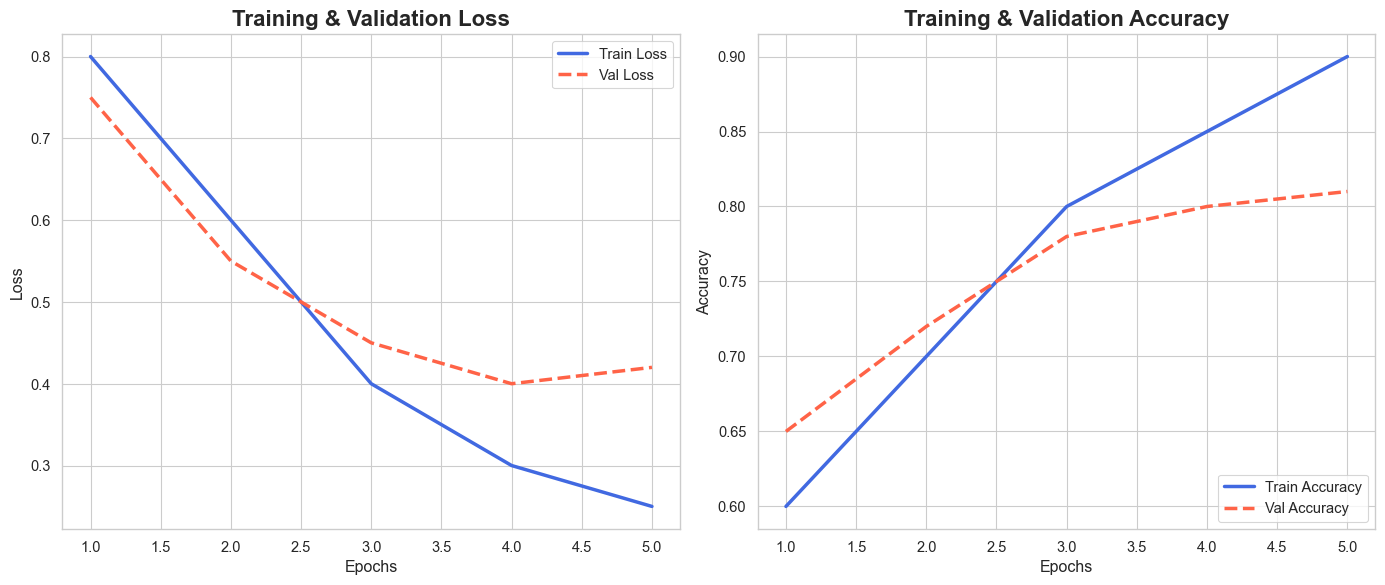

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# [스타일 설정] 논문/보고서용 깔끔한 스타일
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

def plot_learning_curves(history):
    """
    history: dict, {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
             Keras/TensorFlow의 history.history 객체 또는 동일한 구조의 딕셔너리
    """
    epochs = range(1, len(history['loss']) + 1)
    
    # 캔버스 생성 (가로 14, 세로 6)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Loss Curve (손실 곡선)
    sns.lineplot(x=epochs, y=history['loss'], ax=axes[0], label='Train Loss', linewidth=2.5, color='royalblue')
    sns.lineplot(x=epochs, y=history['val_loss'], ax=axes[0], label='Val Loss', linewidth=2.5, color='tomato', linestyle='--')
    axes[0].set_title('Training & Validation Loss', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='upper right')
    
    # 2. Accuracy Curve (정확도 곡선)
    sns.lineplot(x=epochs, y=history['accuracy'], ax=axes[1], label='Train Accuracy', linewidth=2.5, color='royalblue')
    sns.lineplot(x=epochs, y=history['val_accuracy'], ax=axes[1], label='Val Accuracy', linewidth=2.5, color='tomato', linestyle='--')
    axes[1].set_title('Training & Validation Accuracy', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

# [사용 예시] 가상의 데이터 생성 후 실행
mock_history = {
    'loss': [0.8, 0.6, 0.4, 0.3, 0.25],
    'val_loss': [0.75, 0.55, 0.45, 0.40, 0.42], # 과적합 조짐 예시
    'accuracy': [0.6, 0.7, 0.8, 0.85, 0.9],
    'val_accuracy': [0.65, 0.72, 0.78, 0.80, 0.81]
}

plot_learning_curves(mock_history)

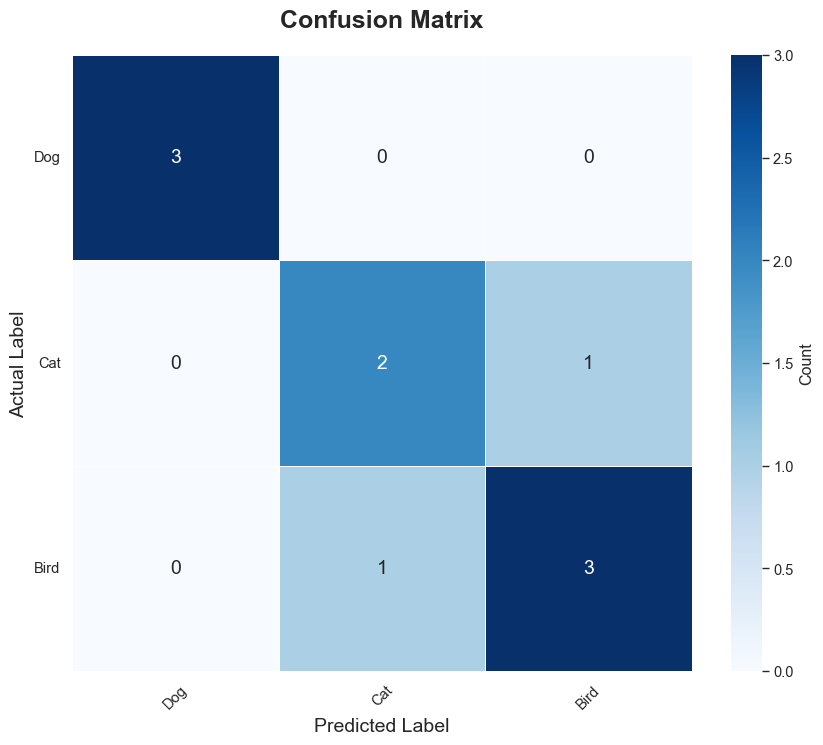

In [3]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    y_true: 실제 라벨 리스트
    y_pred: 예측 라벨 리스트
    classes: 클래스 이름 리스트 (예: ['Dog', 'Cat', 'Bird'])
    """
    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred)
    
    # 데이터프레임 변환 (라벨링을 위해)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    
    plt.figure(figsize=(10, 8))
    
    # Heatmap 그리기
    # annot=True: 숫자 표시, fmt='d': 정수 표기, cmap='Blues': 파란색 계열
    heatmap = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', 
                          linewidths=.5, cbar_kws={'label': 'Count'}, annot_kws={"size": 14})
    
    plt.title('Confusion Matrix', fontsize=18, fontweight='bold', pad=20)
    plt.ylabel('Actual Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45) # 라벨이 길 경우 회전
    plt.yticks(rotation=0)
    plt.show()

# [사용 예시]
y_true_mock = [0, 1, 2, 0, 1, 2, 0, 1, 2, 2] # 0: Dog, 1: Cat, 2: Bird
y_pred_mock = [0, 1, 1, 0, 1, 2, 0, 2, 2, 2] # 모델이 일부 틀린 상황 가정
class_names = ['Dog', 'Cat', 'Bird']

plot_confusion_matrix(y_true_mock, y_pred_mock, class_names)


In [ ]:
test_df = pd.read_csv('../data/01_raw/test.csv')
tain_df = pd.read_csv('../data/01_raw/train.csv')

In [7]:
!pip install tensorflow

  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 2.4/332.0 MB 11.7 MB/s eta 0:00:29
    --------------------------------------- 4.7/332.0 MB 11.8 MB/s eta 0:00:28
    --------------------------------------- 7.3/332.0 MB 11.8 MB/s eta 0:00:28
   - -------------------------------------- 9.7/332.0 MB 11.8 MB/s eta 0:00:28
   - -------------------------------------- 12.3/332.0 MB 11.8 MB/s eta 0:00:28
   - -------------------------------------- 14.9/332.0 MB 11.8 MB/s eta 0:00:27
   -- ------------------------------------- 17.3/332.0 MB 11.8 MB/s eta 0:00:27
   -- ------------------------------------- 19.9/332.0 MB 11.8 MB/s eta 0:00:27
   -- ------------------------------------- 22.3/332.0 MB 11.8 MB/s eta 0:00:27
   --- ------------------------------------ 24.9/332.0 MB 11.8 MB/s eta 0:00:27
   --- ------------------------------------ 25.2/332.0 M

c:\Users\user\miniconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


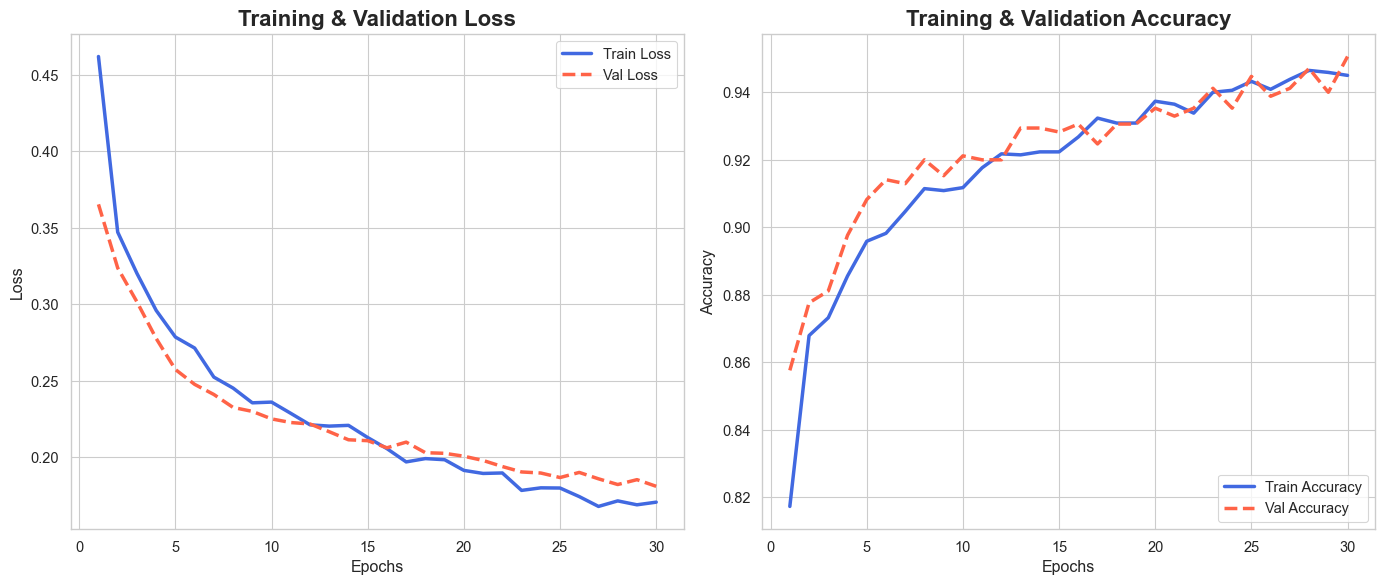

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# [1] 데이터 로드 및 전처리
def load_and_preprocess(filepath):
    # CSV 파일 읽기
    df = pd.read_csv(filepath)
    
    # 분석에 불필요하거나 복잡한 컬럼 제거 (state, area_code)
    # 실제 프로젝트에서는 이 변수들도 인코딩하여 활용할 수 있습니다.
    cols_to_drop = ['state', 'area_code'] 
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    
    # 범주형 데이터(Yes/No)를 수치형(1/0)으로 변환
    # 'churn' 컬럼이 타겟 변수입니다.
    binary_cols = ['international_plan', 'voice_mail_plan', 'churn']
    le = LabelEncoder()
    
    for col in binary_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col])
            
    return df

# 데이터 준비
file_path = '../data/01_raw/train.csv' # 업로드된 파일명
df = load_and_preprocess(file_path)

# Feature(X)와 Target(y) 분리
target_col = 'churn'
X = df.drop(target_col, axis=1)
y = df[target_col]

# 학습/검증 데이터 분리 (80% 학습, 20% 검증)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링 (Data Leakage 방지를 위해 Train셋 기준으로 fit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# [2] 모델 정의 및 학습 (Keras Sequential)
model = Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dropout(0.3), # 과적합 방지를 위한 드롭아웃
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # 이진 분류(Churn 여부)이므로 Sigmoid 사용
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 학습 실행 (로그를 history 객체에 저장)
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=30, 
                    batch_size=32, 
                    verbose=0) # verbose=0: 학습 로그 출력 생략

# [3] 시각화 함수 (요청하신 스타일 적용)
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

def plot_learning_curves(history_dict):
    """
    history_dict: model.fit() 실행 결과인 history.history 딕셔너리
    """
    epochs_range = range(1, len(history_dict['loss']) + 1)
    
    # 캔버스 생성 (가로 14, 세로 6)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Loss Curve (손실 곡선)
    sns.lineplot(x=epochs_range, y=history_dict['loss'], ax=axes[0], 
                 label='Train Loss', linewidth=2.5, color='royalblue')
    sns.lineplot(x=epochs_range, y=history_dict['val_loss'], ax=axes[0], 
                 label='Val Loss', linewidth=2.5, color='tomato', linestyle='--')
    
    axes[0].set_title('Training & Validation Loss', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='upper right', frameon=True)
    
    # 2. Accuracy Curve (정확도 곡선)
    sns.lineplot(x=epochs_range, y=history_dict['accuracy'], ax=axes[1], 
                 label='Train Accuracy', linewidth=2.5, color='royalblue')
    sns.lineplot(x=epochs_range, y=history_dict['val_accuracy'], ax=axes[1], 
                 label='Val Accuracy', linewidth=2.5, color='tomato', linestyle='--')
    
    axes[1].set_title('Training & Validation Accuracy', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='lower right', frameon=True)
    
    plt.tight_layout()
    plt.show() # 혹은 plt.savefig('learning_curve.png')로 저장

# 시각화 실행
plot_learning_curves(history.history)

In [9]:
!pip install yfinance

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ------------------------------- -------- 2.4/3.0 MB 11.8 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 10.9 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 11.0 MB/s  0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15703 sha256=307e74b9d8421be5becb1f73021f28a259bd0c5e86757f8fffe6ec49de0f68fb
  Stored in directory: c:\users\user

  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334
